In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
dowjones = pd.read_csv('monthly dowjones Trading Strategy v2.csv')
dowjones.head(10)

,TICKER,date,SICCD,COMNAM,market_cap,SHROUT,VOL,PRC,ASKHI,BIDLO,...,Ask_minus_Bid,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_2,move_avg_3,lasso_pred,pred_forest,log_pred
0,AAPL,2023-03-31,3571,APPLE INC,-0.951357,1.258002,0.886750,-0.983584,-0.918259,-1.036421,...,0.665754,9,0,1,1,0,0,0.023844,0.060178,Positive
1,AAPL,2023-04-30,3571,APPLE INC,-0.406307,0.383417,-1.042844,-0.415470,-0.641525,-0.188895,...,-1.542094,9,0,1,1,0,0,0.023844,0.014458,Positive
2,AAPL,2023-05-31,3571,APPLE INC,0.046329,0.417647,-0.159913,0.011514,-0.099471,0.052874,...,-0.547261,9,0,1,1,0,0,0.023844,0.075903,Positive
3,AAPL,2023-06-30,3571,APPLE INC,0.736660,0.381285,0.335758,0.668659,0.763821,0.726443,...,-0.044962,9,1,1,1,0,0,0.023844,-0.021904,Positive
4,AAPL,2023-07-31,3571,APPLE INC,1.160363,-0.391033,-1.203948,1.126721,0.977789,1.242505,...,-1.229836,9,1,0,1,0,0,0.023844,0.014458,Positive
5,AAPL,2023-08-31,3571,APPLE INC,0.484635,-0.474761,-0.220681,0.488344,0.892202,0.461159,...,1.400365,9,0,1,1,1,1,0.023844,-0.013595,Positive
6,AAPL,2023-09-30,3571,APPLE INC,0.240771,-0.514517,0.986193,0.258349,0.507058,0.229530,...,0.917963,9,0,1,1,1,1,0.023844,0.023142,Positive
7,AAPL,2023-10-31,3571,APPLE INC,0.050665,-1.260636,-0.750168,0.126824,0.071133,0.125458,...,-0.220990,9,0,1,1,1,1,0.023844,0.084837,Positive
8,AAPL,2023-11-30,3571,APPLE INC,0.710761,-1.244459,-0.926652,0.758612,0.675380,0.362957,...,1.008037,9,0,1,1,0,0,0.023844,0.014458,Positive
9,ABBV,2023-03-31,2834,ABBVIE INC,0.964325,1.291127,1.397388,0.946178,0.648974,1.072496,...,-0.193673,2,1,1,1,0,1,0.023844,0.103068,Negative


In [3]:
dowjones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TICKER             252 non-null    object 
 1   date               252 non-null    object 
 2   SICCD              252 non-null    int64  
 3   COMNAM             252 non-null    object 
 4   market_cap         252 non-null    float64
 5   SHROUT             252 non-null    float64
 6   VOL                252 non-null    float64
 7   PRC                252 non-null    float64
 8   ASKHI              252 non-null    float64
 9   BIDLO              252 non-null    float64
 10  total              252 non-null    int64  
 11  negative           252 non-null    int64  
 12  positive           252 non-null    int64  
 13  sprtrn             252 non-null    float64
 14  RET                252 non-null    float64
 15  next_month_return  252 non-null    float64
 16  last_month_return  252 non

In [4]:
# Change date column to datetime with %Y-%m-%d format
dowjones['date'] = pd.to_datetime(dowjones['date'], format='%Y-%m-%d')

# Change SICCD column to object
dowjones['SICCD'] = dowjones['SICCD'].astype(str)

# Change proper. column to object
dowjones['proper'] = dowjones['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(dowjones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             252 non-null    object        
 1   date               252 non-null    datetime64[ns]
 2   SICCD              252 non-null    object        
 3   COMNAM             252 non-null    object        
 4   market_cap         252 non-null    float64       
 5   SHROUT             252 non-null    float64       
 6   VOL                252 non-null    float64       
 7   PRC                252 non-null    float64       
 8   ASKHI              252 non-null    float64       
 9   BIDLO              252 non-null    float64       
 10  total              252 non-null    int64         
 11  negative           252 non-null    int64         
 12  positive           252 non-null    int64         
 13  sprtrn             252 non-null    float64       
 14  RET       

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_month_return' column
dowjones.dropna(subset=['next_month_return'], inplace=True)

# Select only numeric columns
numeric_columns = dowjones.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[dowjones['next_month_return'] >= 0]
negative_return = numeric_columns[dowjones['next_month_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_next_month_return'] = mean_negative_return
result_df['mean_positive_next_month_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                   negative_next_month_return  \
market_cap                              0.370   
SHROUT                                 -0.026   
VOL                                    -0.264   
PRC                                     0.387   
ASKHI                                   0.354   
BIDLO                                   0.426   
total                                  19.535   
negative                                0.192   
positive                                3.384   
sprtrn                                 -0.283   
RET                                     0.144   
next_month_return                      -0.045   
last_month_return                       0.074   
last_month_volume                      -0.003   
X1_month_ma                             0.387   
X2_month_ma                             0.321   
X3_month_ma                             0.291   
Ask_minus_Bid                          -0.055   
comp_size                               4.091   
dummy_negative      

C:\Users\joel3\AppData\Local\Temp\ipykernel_8768\2639728762.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)


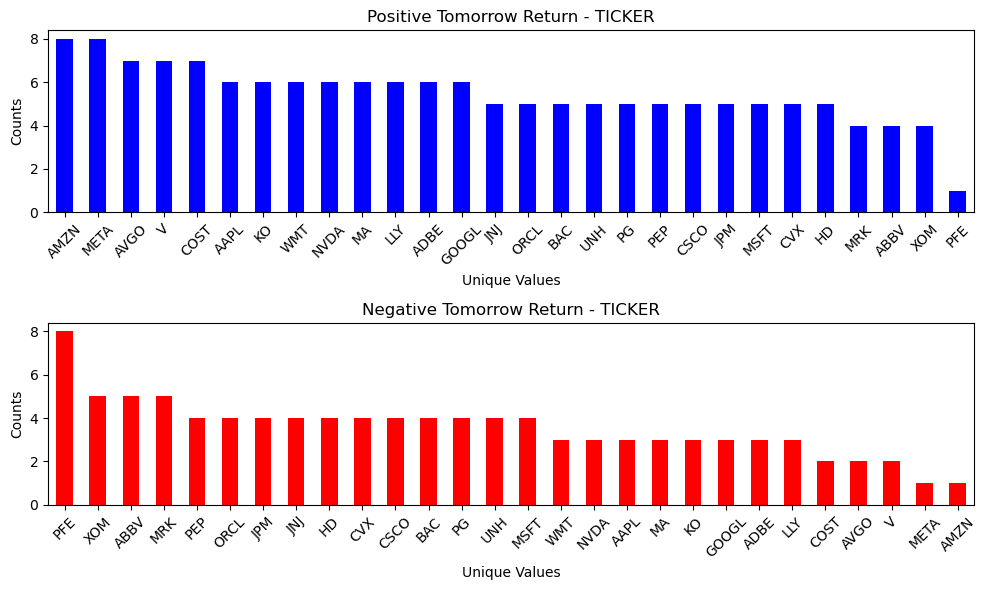

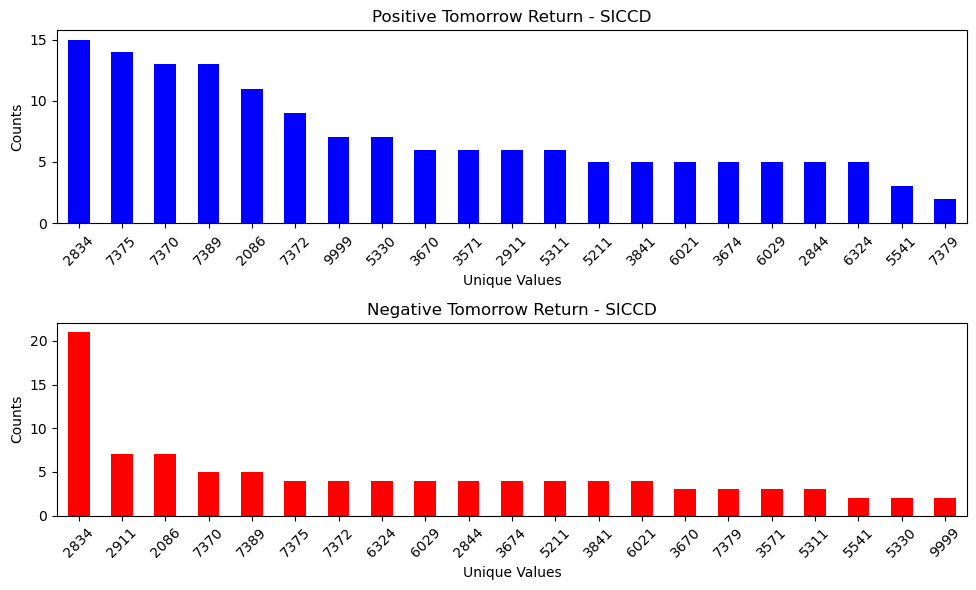

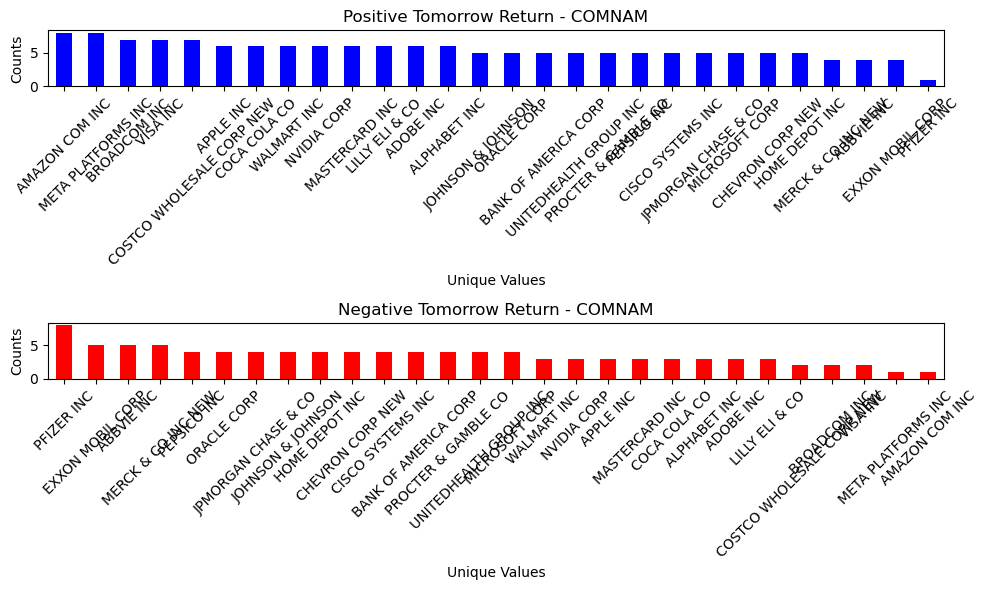

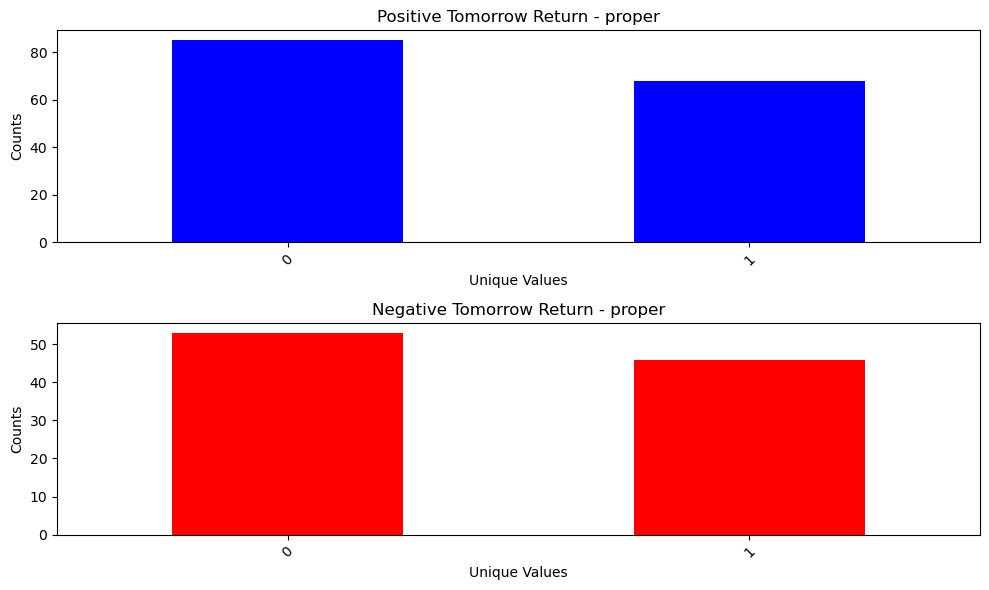

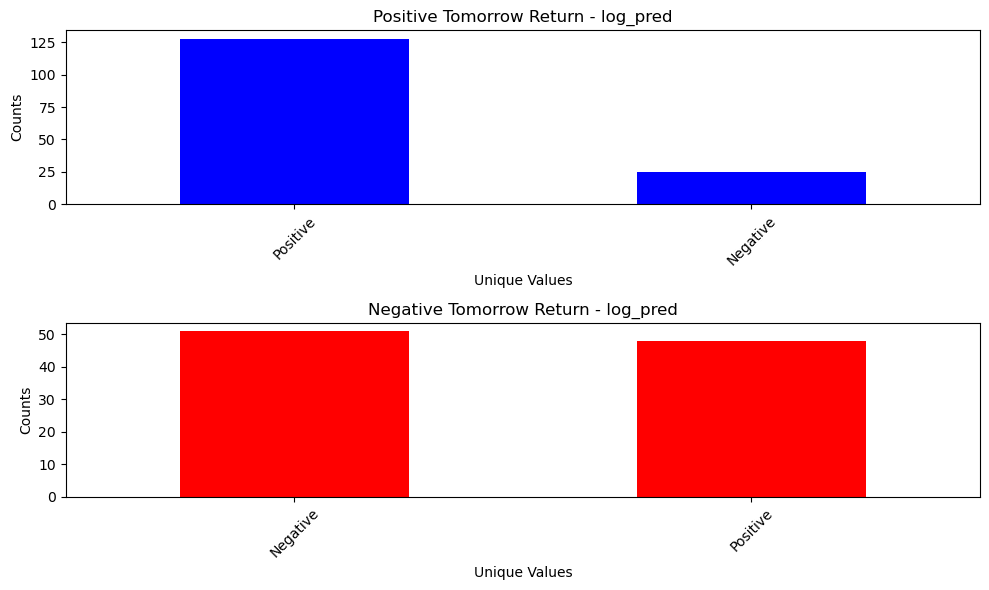

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_month_return' column
dowjones.dropna(subset=['next_month_return'], inplace=True)

# Select only categorical columns
categorical_columns = dowjones.select_dtypes(include=['object'])

# Create subsets
positive_return = dowjones[dowjones['next_month_return'] >= 0]
negative_return = dowjones[dowjones['next_month_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

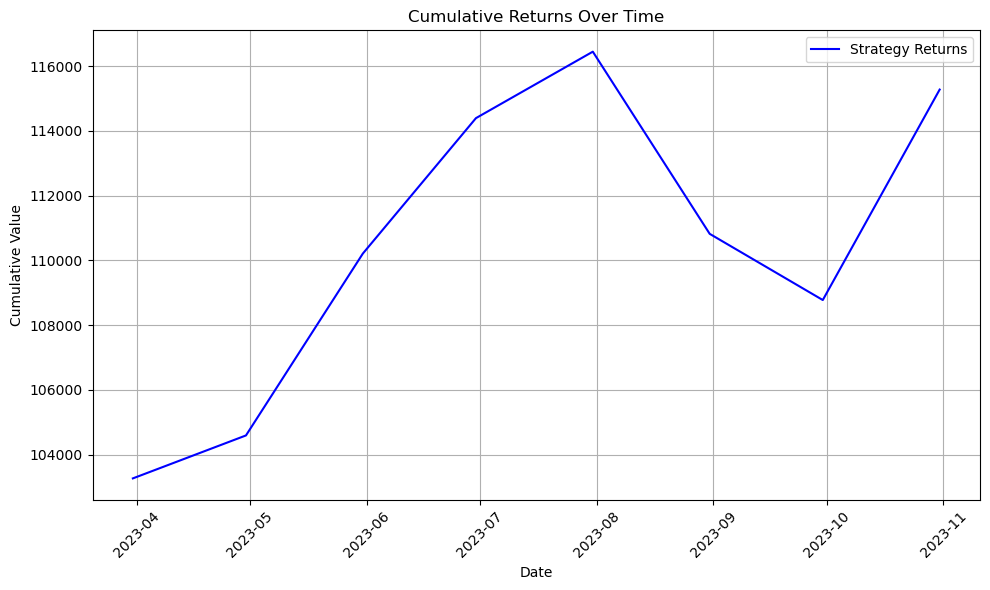

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy.loc[(dowjones_copy['total'] > 10), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


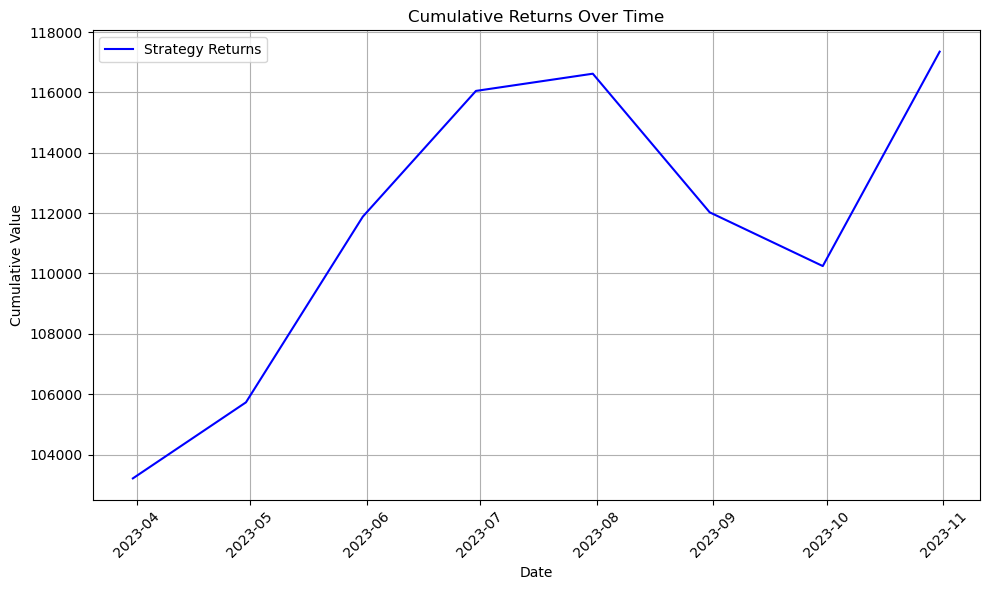

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['lasso_pred'] > 0), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


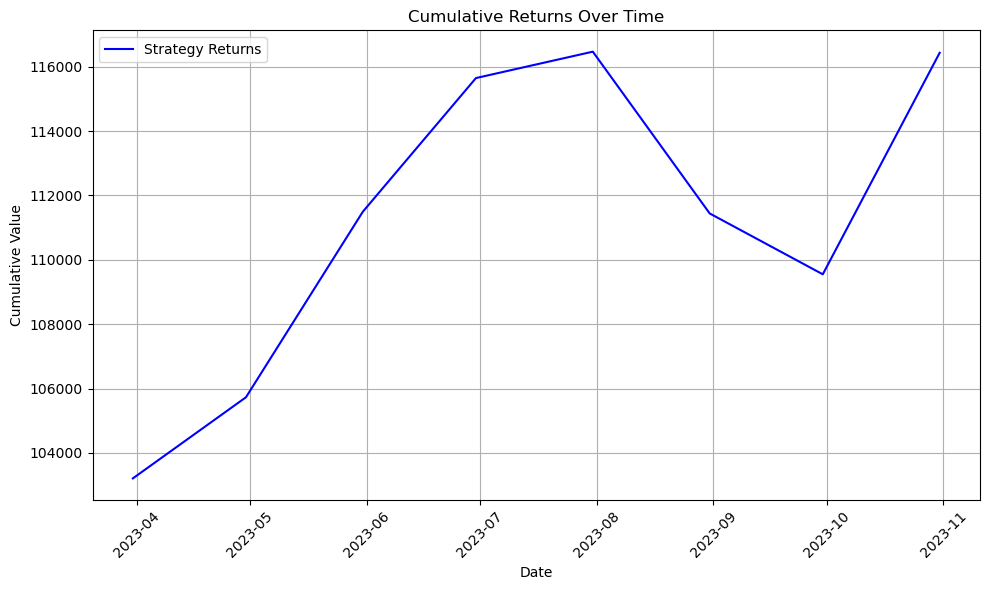

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['total'] > 2), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


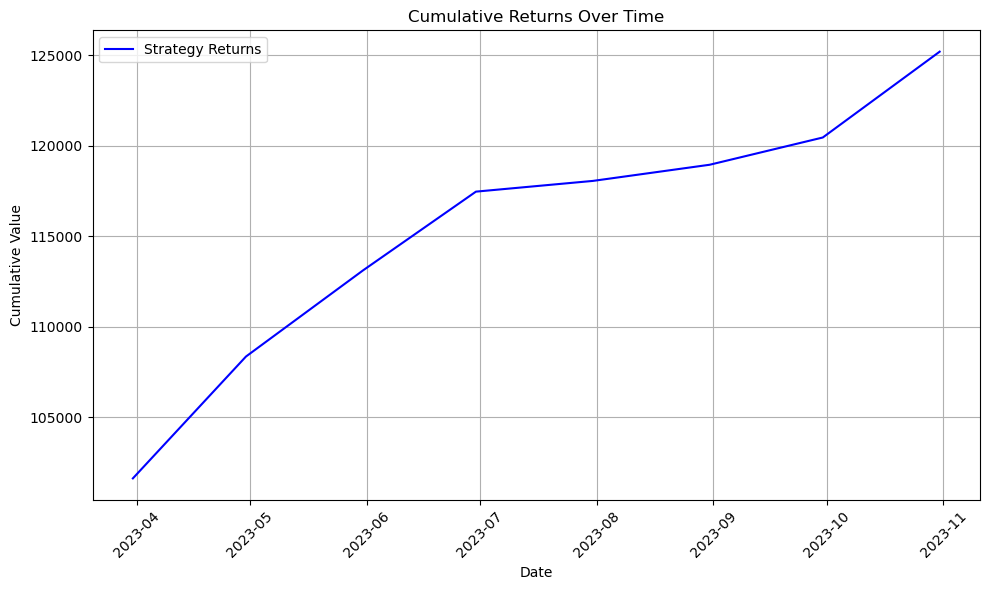

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Positive'), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


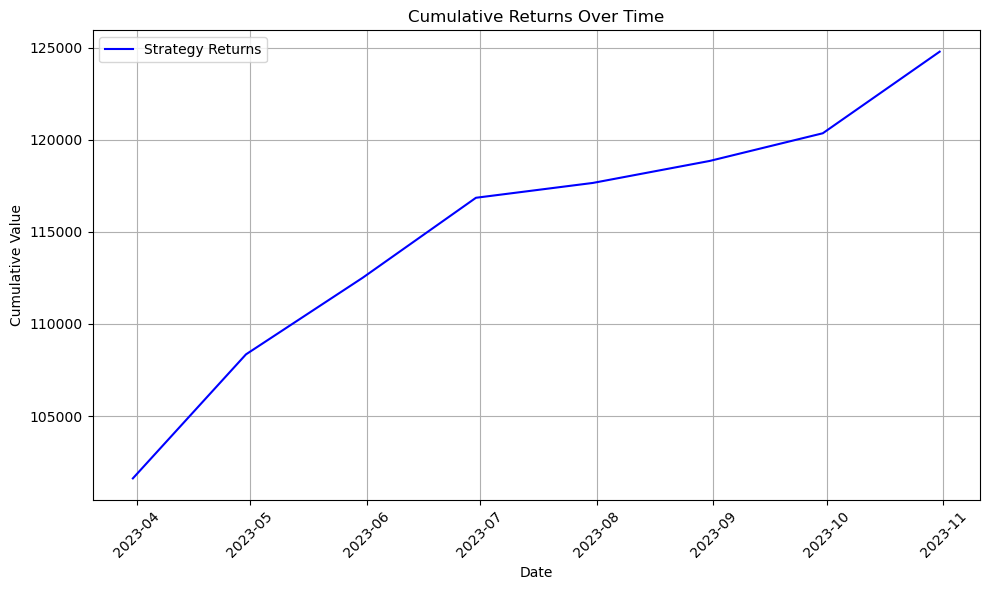

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Positive') & (dowjones_copy['total'] > 2), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Negative') & (dowjones_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


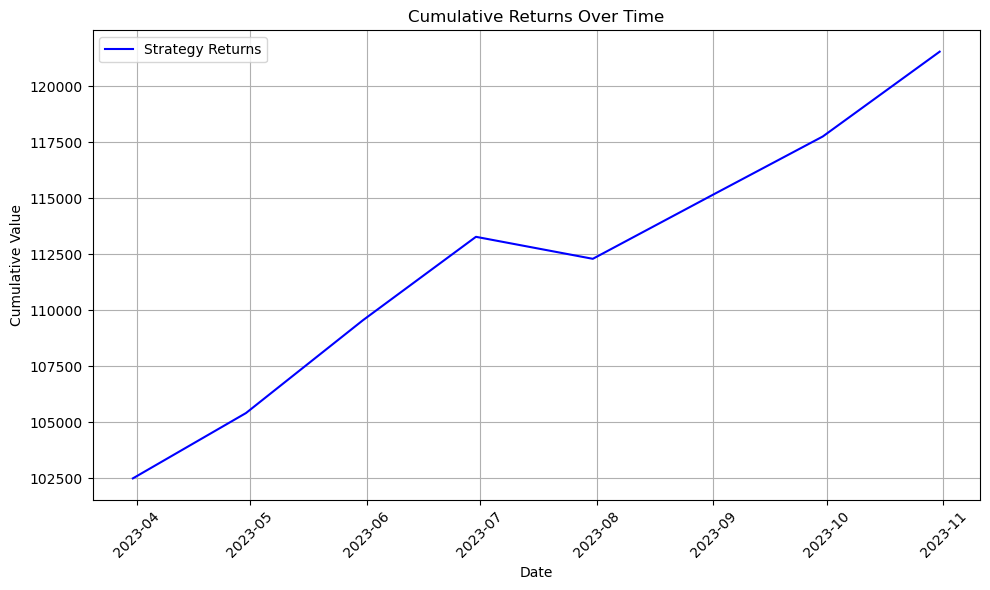

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


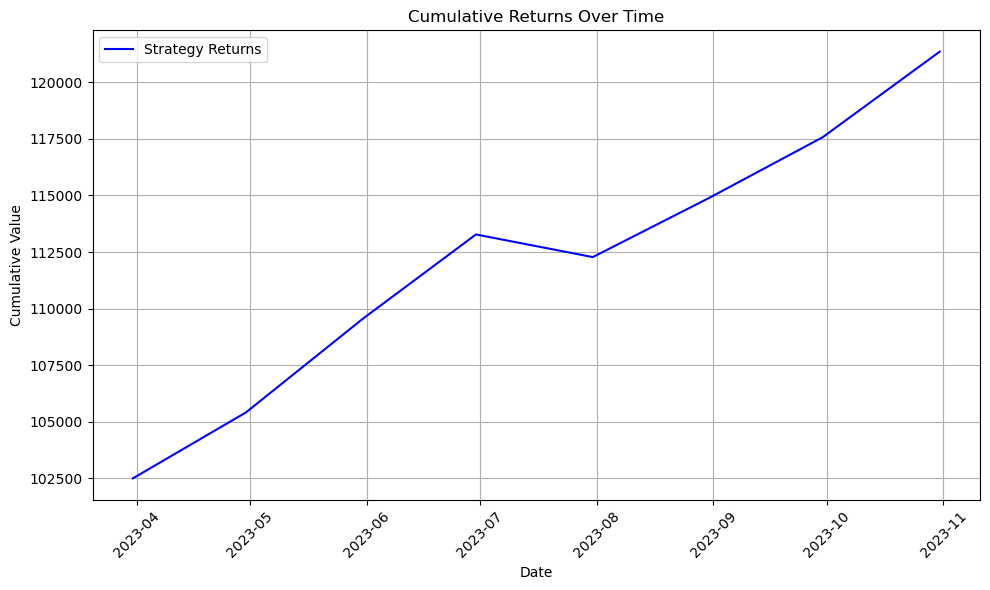

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


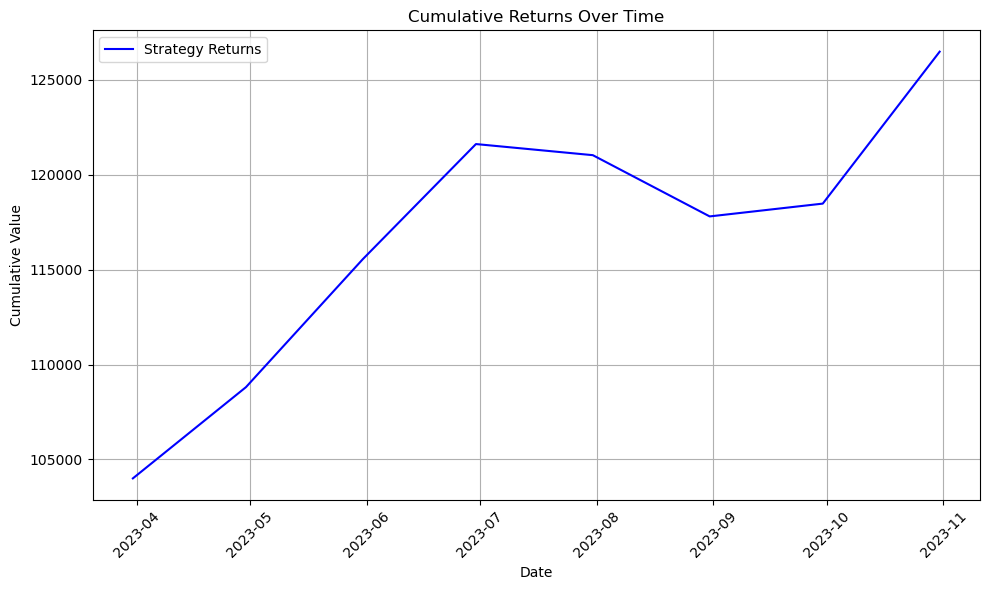

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


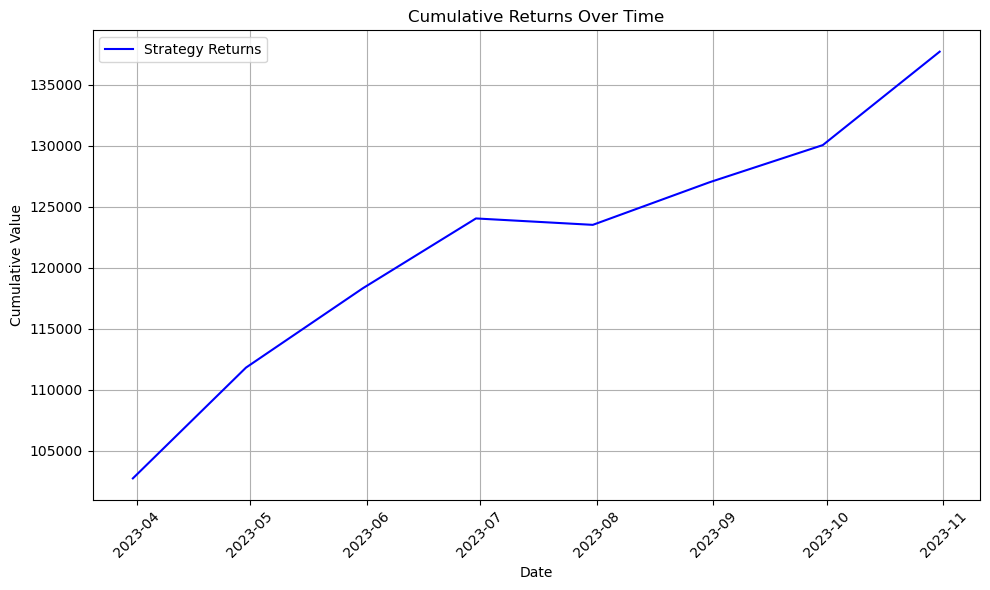

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['log_pred'] == 'Positive') & (dowjones_copy['dummy_total'] == 1), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['log_pred'] == 'Negative') & (dowjones_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


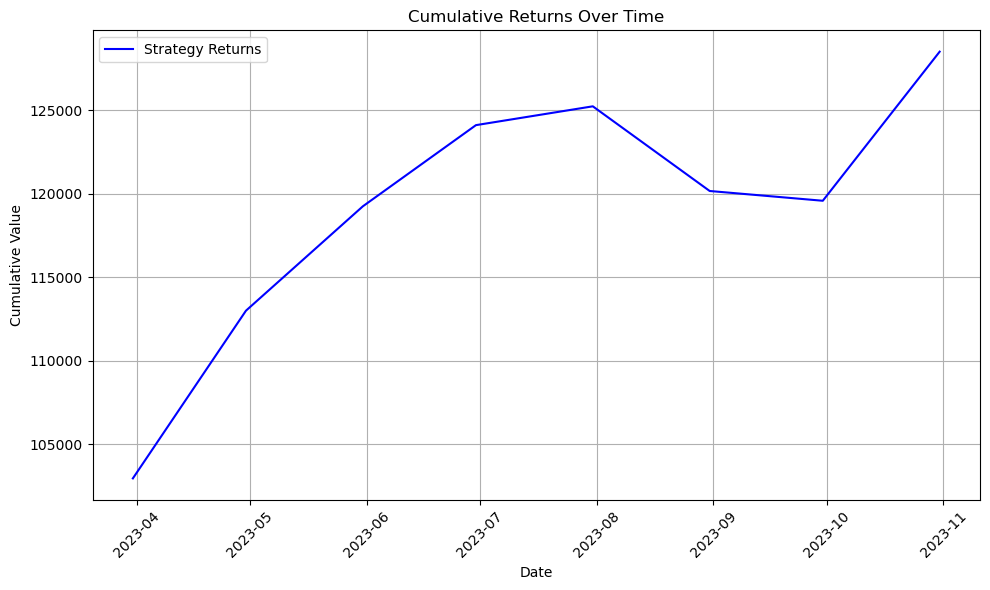

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Positive') & (dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['total'] > 2), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Negative') & (dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


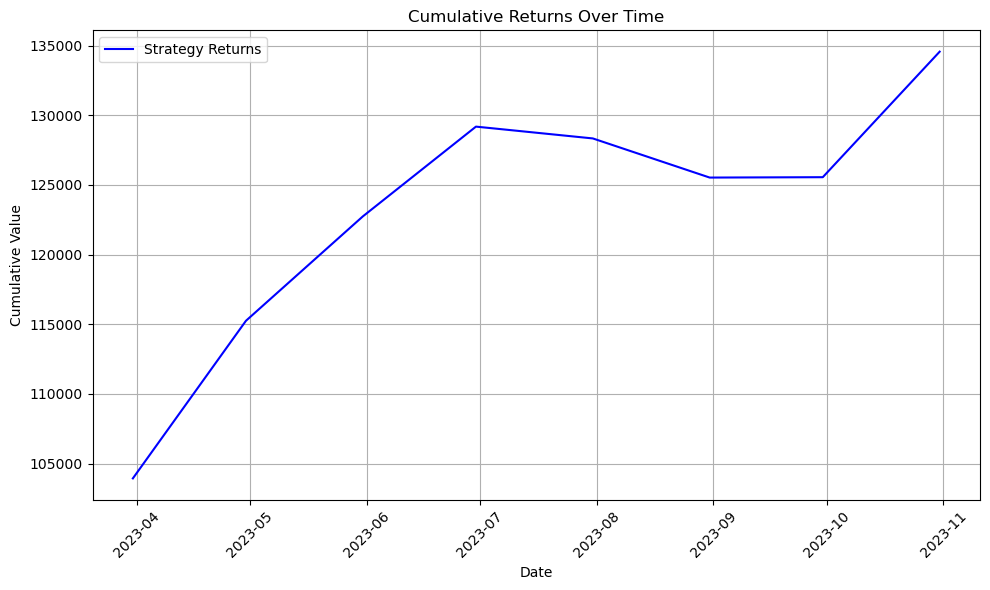

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['dummy_total'] == 1) & (dowjones_copy['log_pred'] == 'Positive'), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['dummy_total'] == 1) & (dowjones_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
